In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [22]:
# Load the images and masks
img_path_1 = "/Users/senneloobuyck/Documents/Thesis_project/03_postprocessing/main_7_output/frames/2023_RVV_1_frame_1236.jpg"
img_path_2 = "/Users/senneloobuyck/Documents/Thesis_project/03_postprocessing/main_7_output/frames/2023_RVV_1_frame_1239.jpg"
mask_path_1 = "/Users/senneloobuyck/Documents/Thesis_project/03_postprocessing/main_7_output/masks/2023_RVV_1_mask_1236.jpg"
mask_path_2 = "/Users/senneloobuyck/Documents/Thesis_project/03_postprocessing/main_7_output/masks/2023_RVV_1_mask_1239.jpg"
img1 = cv2.imread(img_path_1)
img2 = cv2.imread(img_path_2)
mask1 = cv2.imread(mask_path_1)
mask2 = cv2.imread(mask_path_2)

# Destination folders for the stitched images and masks
img_stitched_folder = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/stitched_frames"
mask_stitched_folder = "/Users/senneloobuyck/Documents/Thesis_project/04_matching/main_7/stitched_masks"

In [23]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [26]:
def stitch_frames(frame, pred_mask, next_frame, next_pred_mask, img_path_frame) :
    
    h1, w1 = next_frame.shape[:2]
    h2, w2 = frame.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(image=next_frame, mask=None)
    keypoints2, descriptors2 = sift.detectAndCompute(image=frame, mask=None)
    # match keypoints
    bf = cv2.BFMatcher()
    # k = 2 to get 2 best matches for each keypoint
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    # apply ratio test to select good matches
    good_matches = []
    for m1, m2 in matches: # m1 = best match, m2 = second best match
        if m1.distance < 0.6 * m2.distance:
            good_matches.append(m1)


    # how many good matches 
    print(f"Number of good matches: {len(good_matches)}")
    # now draw good matches
    # result = cv2.drawMatches(image1, keypoints1, image2, keypoints2, good_matches, None, flags=2, matchesThickness=5)
    # plot_images(images)
    # plot_images(masks)
    # plot_image(result)
    # find homography matrix using RANSAC
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    print("Length src_pts")
    print(len(src_pts))
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    print("Length dst_pts")
    print(len(dst_pts))

    if len(src_pts) >= 8 and len(dst_pts) >= 8:
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        print(f"Homography matrix: {H}")
    
        warped_corners1 = cv2.perspectiveTransform(corners1, H)
    
        corners = np.concatenate((corners2, warped_corners1), axis=0)
        [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
    
        t = [-xmin, -ymin]
        Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])
    
        warped_img1 = cv2.warpPerspective(next_frame, Ht @ H, (xmax - xmin, ymax - ymin))
        plot_image(warped_img1)
        blended_img_1 = cv2.addWeighted(warped_img1[t[1]:h1 + t[1], t[0]:w1 + t[0]], 0.8, frame, 0.5, 0)
        plot_image(blended_img_1)
        warped_img1[t[1]:h1 + t[1], t[0]:w1 + t[0]] = frame
    
        warped_mask1 = cv2.warpPerspective(next_pred_mask, Ht @ H, (xmax - xmin, ymax - ymin))
        # warped_mask1[t[1]:h1 + t[1], t[0]:w1 + t[0]] += pred_mask
    
        warped_mask1 = warped_mask1/255
        pred_mask = pred_mask/255
    
        result = np.logical_or(warped_mask1[t[1]:h1 + t[1], t[0]:w1 + t[0]], pred_mask).astype(np.uint8)
        warped_mask1[t[1]:h1 + t[1], t[0]:w1 + t[0]] = result
        result = (result*255).astype(np.uint8)
        warped_mask1 = (warped_mask1*255).astype(np.uint8)
        pred_mask = (pred_mask*255).astype(np.uint8)

        frame_name = img_path_frame.split("/")[-1]
        mask_name = frame_name.replace("frame", "mask")

        plot_image(warped_img1)
        plot_image(warped_mask1)
        cv2.imwrite(os.path.join(img_stitched_folder, frame_name), warped_img1)
        cv2.imwrite(os.path.join(mask_stitched_folder, mask_name), warped_mask1)

    else:
        print("Insufficient corresponding points to estimate the homography, only using the current frame")

        img1_name = img_path_1.split("/")[-1]

        plot_image(next_frame)
        plot_image(next_pred_mask)
        cv2.imwrite(os.path.join(img_stitched_folder, frame_name), frame)
        cv2.imwrite(os.path.join(mask_stitched_folder, mask_name), pred_mask)

Number of good matches: 13
Length src_pts
13
Length dst_pts
13
Homography matrix: [[ 5.01393586e-01 -2.61931523e-01  3.41770316e+02]
 [ 3.90297163e-01  1.00360868e+00 -1.54621716e+02]
 [-9.18089588e-04  1.08568974e-04  1.00000000e+00]]


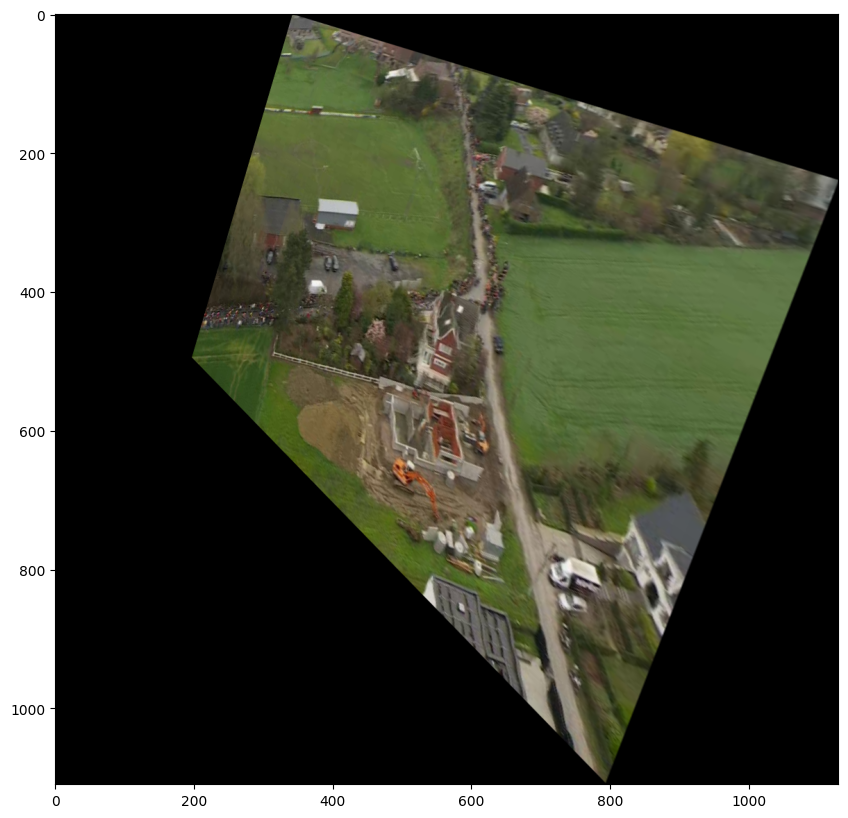

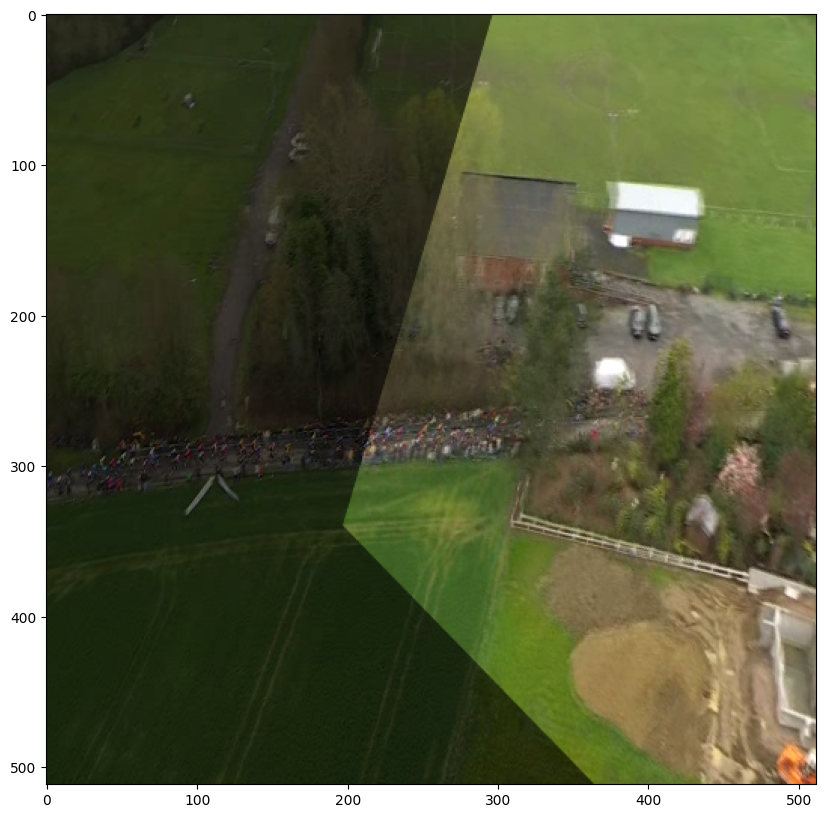

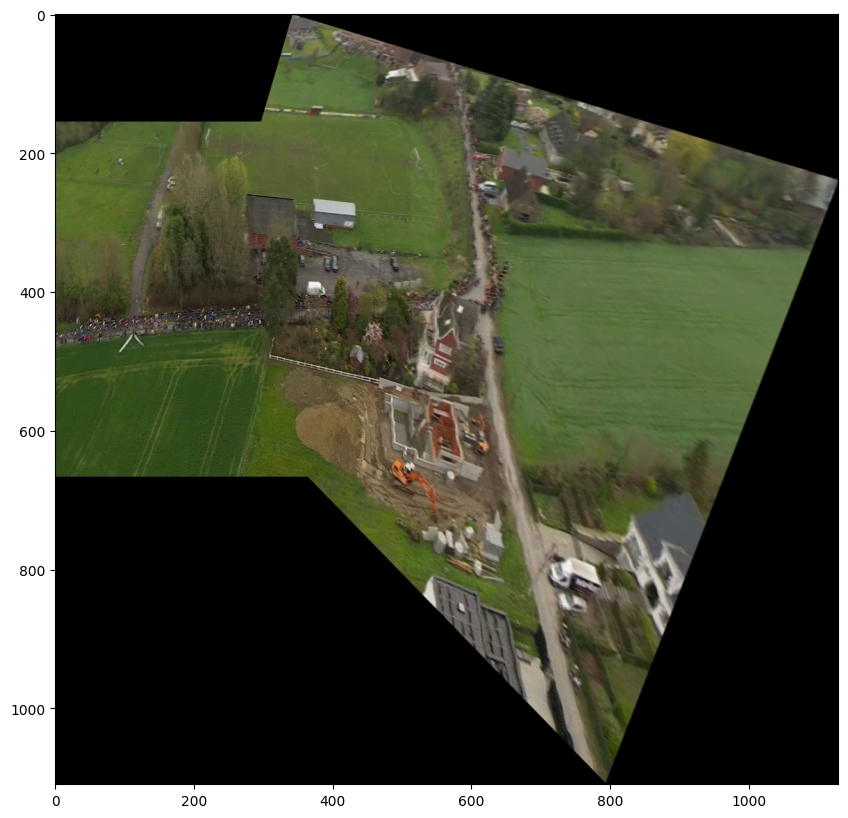

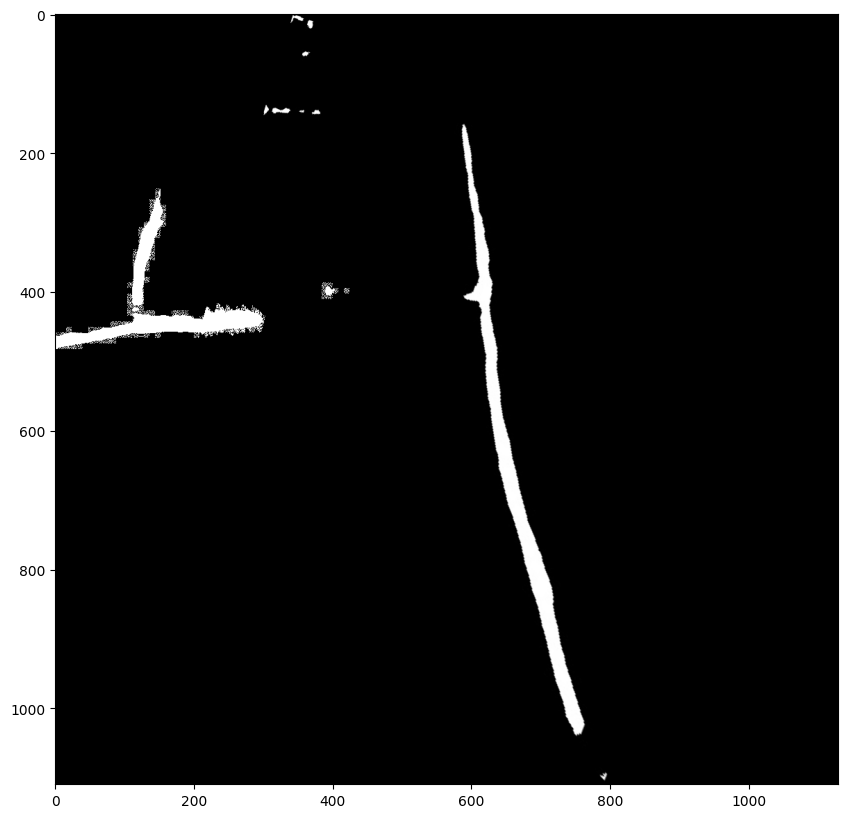

In [27]:
stiched = stitch_frames(img1, mask1, img2, mask2, img_path_1)